
# HyeongKyun Kim 21-732-797
# Songyi Han 18-796-847

*This assignment is done by **HyeongKyun Kim** and **SongYi Han** - We both **equally contributed** to this work by writing our own code individually first and then compare/merge them together.*


# A07: Analysis of Financial Networks

In [1]:
import networkx as nx

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

In [2]:
cormat_1h = np.load('../Data/cormat_1h.npy')
cormat_1m = np.load('../Data/cormat_1m.npy')

with open('../Data/stocknames.txt') as file:
    lines = file.readlines()
    tickers = [line.rstrip() for line in lines]
    
Q_1h = 3.6289
Q_1m = 200.8969

# A07.1 The Marčenko-Pastur law


*Task: For the 97 most capitalized stocks in the NY Stock Exchange, filter the correlation matrix of returns at the 1 hour and 1 minute timescales using Marčenko-Pastur law.*

For each of the provided correlation matrices (for 1 hour and 1 minute returns):
+ compute the eigenvalues and eigenvectors
+ plot the histogram of eigenvalues and superimpose the Marčenko-Pastur law with parameter
    - for hourly returns, 𝑄 = 3.6289
    - for minute returns, 𝑄 = 200.8969
+ compute the denoised correlations (see lecture)


A07.1 Hints
+ eigenvalues and vectors are obtained through
numpy.linalg.eig()
+ in the Marčenko-Pastur equation, 𝜎 = 1 since we have
correlations
+ the denoised correlation matrix 𝑌 may have diagonal
𝑌𝑖𝑖 ≠ 1:
    - define the diagonal matrix 𝐷 s.t. 𝐷𝑖𝑖 =
1
√𝑌𝑖𝑖
    - rescale 𝑌 to have unit diagonal by doing
𝑌 = 𝐷 ̃ 𝑌𝐷
    - Eigenvectors of 𝑌̃are rescaled by 𝐷 themselves

In [3]:
def plot_hist_mpdensity(emp_data, Q, plot_title):

    ax1 = plt.axes()  # standard axes
    ax2 = plt.axes([0.65, 0.35, 0.2, 0.2])

    # ======================================================
    # 1. [Empirical] Plot the density histogram of the eigenvalues of real covariance matrix(Υ)
    eigval, eigvec = np.linalg.eig(emp_data)
    ax1.hist(eigval, bins = 'auto', density = True, label = 'Empirical Data')
    ax2.hist(eigval, bins = 'auto', density = True, label = 'Empirical Data')
    # ======================================================

    # ======================================================
    # 2. [Theoritical] Plot the Marčenko-Pastur law density

    thr_eigval_min = np.square(1) * (1 + 1/Q - 2*np.sqrt(1/Q))
    thr_eigval_max = np.square(1) * (1 + 1/Q + 2*np.sqrt(1/Q))
    sample_eigval = np.linspace(thr_eigval_min, thr_eigval_max, num=97)

    mp_density = (Q / (2*np.pi*np.square(1)))
    mp_density *= (np.sqrt((thr_eigval_max - sample_eigval)*(sample_eigval - thr_eigval_min)) / (sample_eigval))
     
    ax1.plot(sample_eigval, mp_density, label = 'Marcenko-Pastur law Data')
    ax2.plot(sample_eigval, mp_density, label = 'Marcenko-Pastur law Data')
    # ======================================================

    ax1.set_title(plot_title)
    ax1.set_xlabel('λ')
    ax1.set_ylabel('ρ(λ)')
    ax1.legend()

    ax2.set_xlim([0,thr_eigval_max+1])


def denoised_corr(emp_data, Q):
    # ======================================================
    # 1-1. Prepare eigenvalues and eigenvectors from the empiricial data set.
    eigval, eigvec = np.linalg.eig(emp_data)
    # 1-2. Prepare min, max eigenvalues depending on Q in the Marčenko-Pastur law density
    thr_eigval_max = np.square(1) * (1 + 1/Q + 2*np.sqrt(1/Q))
    # 2. Classified eigenvalues as noise, and signal.
    eigval_flt = eigval
    for i in range(len(eigval)):
        if eigval[i]<thr_eigval_max:
            eigval_flt[i] = 0.5
    # 3. normlization of filtered engenvalues.
    eigval_flt_norm = eigval_flt
    norm=(len(eigval_flt)-sum(eigval_flt))/len(eigval_flt)
    for i in range(len(eigval_flt)):
        eigval_flt_norm[i] = eigval_flt[i] + norm
    # 4. Undo diagonalization to get the denoised correlation matrix.
    denoise_cor_mx = np.dot(np.dot(eigvec, np.diag(eigval_flt_norm)), np.linalg.inv(eigvec))
    # + Rescale the denoised correlation matrix to get value '1' diagonolly.
    np.fill_diagonal(denoise_cor_mx,1)
    return denoise_cor_mx
    
    

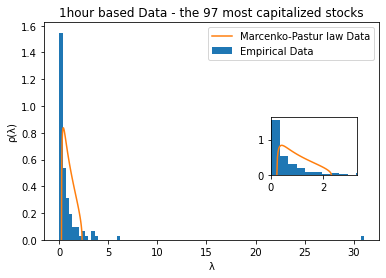

In [4]:
plot_hist_mpdensity(cormat_1h,Q_1h,'1hour based Data - the 97 most capitalized stocks')

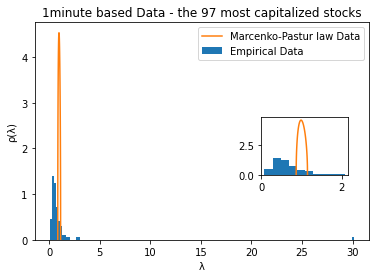

In [5]:
plot_hist_mpdensity(cormat_1m,Q_1m,'1minute based Data - the 97 most capitalized stocks')

In [6]:
denoise_cor_mx_1h = denoised_corr(cormat_1h,Q_1h)
denoise_cor_mx_1m = denoised_corr(cormat_1m,Q_1m)

# A07.2 Correlation MSTs


*Task: Build MSTs from denoised correlations and analyze them*

+ make a scatterplot of the 1 hour vs 1 minute denoised correlations (1 data point per pair of stocks)
+ from the denoised correlation matrices, build the Minimum Spanning Tree (see lecture)
+ assign the correct ticker (’AAPL’, ’AMZN’, …) as an attribute to the nodes and calculate the degrees
+ make a scatterplot of the 1 hour vs 1 minute MST degrees of stocks (1 data point per stock)



A07.2 Hints
+ To build the MST, use
networkx.minimum_spanning_tree on the weighted
undirected graph that is generated by the matrix with
entries 𝑑𝑖𝑗 (see lecture)
+ Assign a ‘ticker’ attribute to nodes by using
networkx.set_node_attributes(G,
values=tickers, name='ticker')
+ WARNING: make sure the order of nodes is the same in the
two degree lists (e.g. ’AAPL’ is item 0, ’AMZN’ is item 1 etc.
for both the 1 minute and 1 hour returns), otherwise you’ll
get the wrong scatterplot

In [7]:
def denoise_corr_to_MST(denoise_cor_mx):
    keys = range(len(tickers))
    attributes = {}
    for i in keys:
        attributes[i] = tickers[i]
    dist_mx = np.sqrt(2*(1-denoise_cor_mx))
    g_dist_mx = nx.from_numpy_matrix(dist_mx)
    mst_dist_mx = nx.minimum_spanning_tree(g_dist_mx)
    nx.set_node_attributes(mst_dist_mx, attributes, 'ticker')
    return mst_dist_mx

Text(0.5, 1.0, 'Denoised Correlations Scatter Plot')

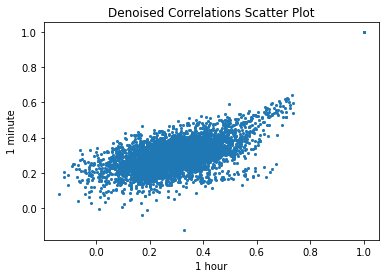

In [8]:
plt.scatter(denoise_cor_mx_1h,denoise_cor_mx_1m, s=3)
plt.xlabel('1 hour')
plt.ylabel('1 minute')
plt.title('Denoised Correlations Scatter Plot')

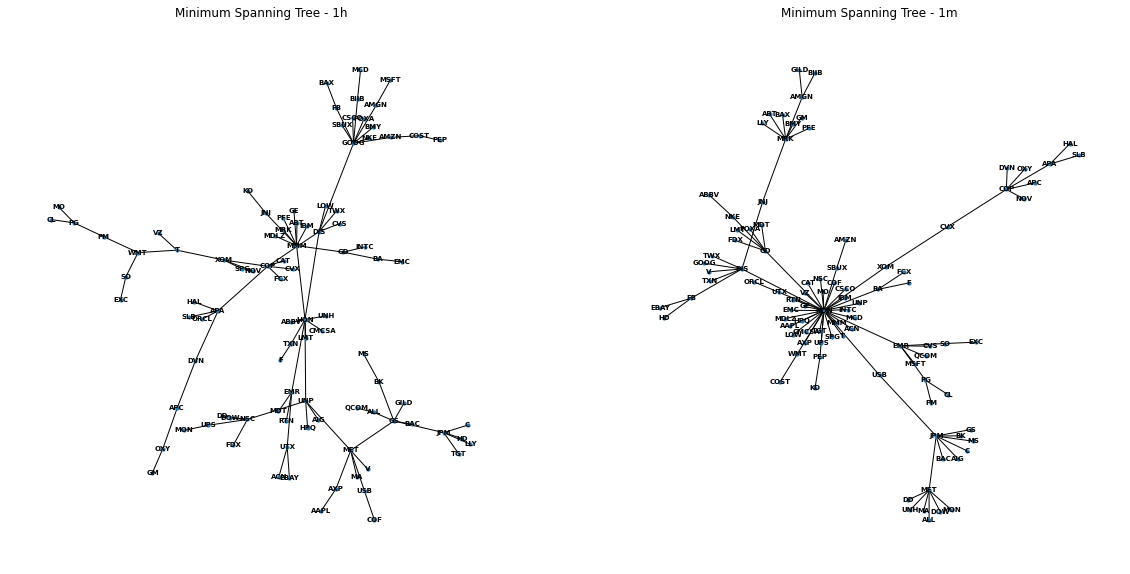

In [9]:
mst_dist_mx_1h = denoise_corr_to_MST(denoise_cor_mx_1h)
mst_dist_mx_1m = denoise_corr_to_MST(denoise_cor_mx_1m)

fig1 = plt.figure(figsize = (20,10))
labels = nx.get_node_attributes(mst_dist_mx_1h, 'ticker')

ax1 = fig1.add_subplot(121)
ax1.set_title('Minimum Spanning Tree - 1h')
nx.draw(mst_dist_mx_1h,labels=labels,node_size=10,font_size=7,font_weight='bold')

ax2 = fig1.add_subplot(122)
ax2.set_title('Minimum Spanning Tree - 1m')
labels = nx.get_node_attributes(mst_dist_mx_1m, 'ticker')
nx.draw(mst_dist_mx_1m,labels=labels,node_size=10,font_size=7,font_weight='bold')

Text(0.5, 1.0, 'MST Degrees Scatter Plot')

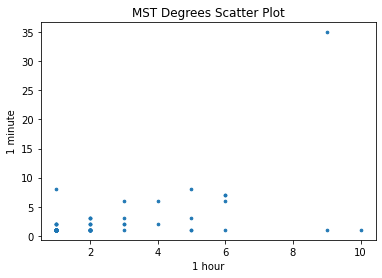

In [10]:
mst_dist_mx_1h_d = [d for d in dict(mst_dist_mx_1h.degree()).values()]
mst_dist_mx_1m_d = [d for d in dict(mst_dist_mx_1m.degree()).values()]

plt.scatter(mst_dist_mx_1h_d,mst_dist_mx_1m_d, s=7)
plt.xlabel('1 hour')
plt.ylabel('1 minute')
plt.title('MST Degrees Scatter Plot')

# A07.3 - Conclusions
*Task: finish the analysis by drawing conclusions*

Answer the following questions (for both timescales):

1. Is there a ‘market mode’?

- Yes, Both have a 'market mode'. We can figure out throught the histogram which has a very large eigenvalue (around 30 for both)


2. Which is the stock that has the strongest relation with the market?
- See the below code result

In [11]:
sum_cor_1h = []
sum_cor_1m = []

for i in range(len(tickers)):
    sum_cor_1h.append(np.sum(denoise_cor_mx_1h[i,:]))
    sum_cor_1m.append(np.sum(denoise_cor_mx_1m[i,:]))
    
max_sum_cor_1h = max(sum_cor_1h)
max_sum_cor_1m = max(sum_cor_1m)

print('the strongest stock')
print('1hour data : ', tickers[sum_cor_1h.index(max_sum_cor_1h)])
print('1minute data : ', tickers[sum_cor_1m.index(max_sum_cor_1m)])

the strongest stock
1hour data :  HON
1minute data :  HON


3. Which are the 5 stocks with highest degree on the MST?
- See the below code result

In [12]:
_ = sorted(np.unique(mst_dist_mx_1h_d), reverse=True)
print('Top 5 stocks with highest degree on the MST - 1 Hour')
for i in range(5):
    index = np.where(mst_dist_mx_1h_d == _[i])[0]
    stocks = ''
    for j in range(len(index)):
        stocks += tickers[index[j]] + ' '
    print(i+1, '.', stocks)

_ = sorted(np.unique(mst_dist_mx_1m_d), reverse=True)
print('\nTop 5 stocks with highest degree on the MST - 1 Minute')
for i in range(5):
    index = np.where(mst_dist_mx_1m_d == _[i])[0]
    stocks = ''
    for j in range(len(index)):
        stocks += tickers[index[j]] + ' '
    print(i+1, '.', stocks)

Top 5 stocks with highest degree on the MST - 1 Hour
1 . GOOG 
2 . HON MMM 
3 . COP DIS GS MET 
4 . APA JPM NSC UNP 
5 . EMR XOM 

Top 5 stocks with highest degree on the MST - 1 Minute
1 . HON 
2 . JPM MRK 
3 . DIS MET 
4 . COP EMR GD 
5 . AMGN APA BA FB PG 


4. Is the degree distribution of MSTs qualitatively the same at
1 minute and 1 hour?
- No, not same. See the below code result

Text(1, 20, 'Pearson r = 0.514521 \nSpearman ρ (rho) = 0.525826 \nKendall τ (tau) = 0.494085 ')

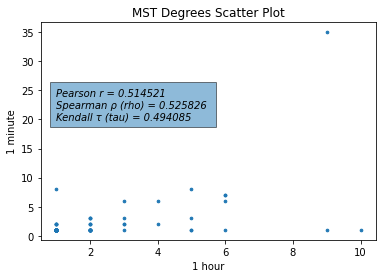

In [13]:
pears = sts.pearsonr(mst_dist_mx_1h_d,mst_dist_mx_1m_d)[0]
spearm = sts.spearmanr(mst_dist_mx_1h_d,mst_dist_mx_1m_d)[0]
kendalt = sts.kendalltau(mst_dist_mx_1h_d,mst_dist_mx_1m_d)[0]

plt.scatter(mst_dist_mx_1h_d,mst_dist_mx_1m_d, s=7)
plt.xlabel('1 hour')
plt.ylabel('1 minute')
plt.title('MST Degrees Scatter Plot')
plt.text(1, 20, 'Pearson r = %f \nSpearman \u03C1 (rho) = %f \nKendall \u03C4 (tau) = %f '%(pears,spearm,kendalt), style='italic',
            bbox={'alpha': 0.5, 'pad': 6})